# Performance assessment


## Determine binary classification statistics 

For the v3 accessibility map, vs:
- phase 2 accessibility map
- permissive
- restrictive
- 50% random classifier

based on:
- Mendelian error in held out crosses (autosomes)
- male het calls (`n_male_het`, `n_males_called`, `all_males_called`) will be used instead of `mendel_error`

In [1]:
# Imports:
import gcsfs
import zarr
import dask.array as da
from dask_kubernetes import KubeCluster
from dask.distributed import Client
import pandas as pd
import numpy as np
import numba
from pathlib import Path

In [2]:
# Settings:

# Note that Mendelian errors (or preferably any data) from these crosses 
# should *not* have been used to compute the phase 2 accessibility map, otherwise it will not be a fair/accurate test.
cross_family_ids = pd.read_csv("performance_eval_crosses.txt", squeeze=True, header=None).values
# Note that the accessibility resource contains data for `UNKN` and `Y_unplaced`
chrom_arms = ['2R', '2L', '3R', '3L', 'X']


In [3]:
cross_family_ids

array(['B5', 'K6', '73-2', '45-1', '37-3'], dtype=object)

In [4]:
n_workers = 40

## Connect to the cloud cluster

In [5]:
cluster = KubeCluster(n_workers=n_workers)
cluster

distributed.scheduler - INFO - Clear task state
/opt/conda/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)
distributed.scheduler - INFO -   Scheduler at: tcp://10.33.164.201:39515
distributed.scheduler - INFO -   dashboard at:                    :45657


In [6]:
client = Client(cluster)
client

distributed.scheduler - INFO - Receive client connection: Client-e01ba92e-8bba-11ea-81a1-467437f7e0ab
distributed.core - INFO - Starting established connection


Client Scheduler: tcp://10.33.164.201:39515 Dashboard: /user/nicholasharding/proxy/45657/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [7]:
# Eyeball the name of this cluster, so we can identify associated worker pods
cluster.name

'dask-nicholasharding-9bc20190-b'

## Connect to the cloud storage

In [8]:
gcs = gcsfs.GCSFileSystem(project='malariagen-jupyterhub', token='cloud', cache_timeout=0)

## Determine which crosses stats (inc. Mendelian error) are predicted by the phase 2 accessibility map

Populate the confusion matrix, such that:
- If the crosses stats imply that a position is accessible ("good") and the phase 2 map also says it is accessible, then mark the prediction as a `True Positive` (`TP`)
- If the crosses stats imply that a position is accessible ("good") but the phase 2 map says it is inaccessible, then mark the prediction as a `False Negative` (`FN`)
- If the crosses stats imply that a position is inaccessible ("bad") and the phase 2 map also says it is inaccessible, then mark the prediction as a `True Negative` (`TN`)
- If the crosses stats imply that a position is inaccessible ("bad") but the phase 2 map says it is accessible, then mark the prediction as a `False Positive` (`FP`)
- If the crosses stats cannot determine whether a position is "good" or "bad" (e.g. there were no male het calls on the X chromosome, but not all samples were called), then mark the prediction result as undetermined and exclude from subsequent stats.

### Include results for artificial classifiers (for comparison)

- random 50% is_accessible
- 100% is_accessible

In [9]:
@numba.njit
def cross_tab_values(eval_arr, test_arr):
    
    out = np.zeros((2, 2))
    
    # TN FP
    # FN TP
    
    # eval arr has 
    for i in range(eval_arr.shape[0]):
        if eval_arr[i] == -1:
            continue
        
        if test_arr[i]:
            out[eval_arr[i], 1] += 1
        else:
            out[eval_arr[i], 0] += 1
    
    return out.reshape((1, 2, 2))

In [10]:
# define intermediate file storage
zarr_access_out_path = Path(
    "vo_agam_production", "accessibility_maps", "v3", "accessibility_proposal", "gamb_colu")

store_access_out = gcsfs.mapping.GCSMap(zarr_access_out_path.as_posix())
accessibility_out = zarr.group(store_access_out)

def load_phase3_accessibility(chrom):
    return da.from_zarr(accessibility_out[chrom]["is_accessible"])

In [11]:
accessibility_gcsmap = gcsfs.mapping.GCSMap('ag1000g-release/phase2.AR1/accessibility/accessibility.zarr', gcs=gcs)
accessibility_zarr = zarr.Group(accessibility_gcsmap, read_only=True)

def load_phase2_accessibility(chrom):
    
    phase2_is_accessible = da.from_zarr(accessibility_zarr[chrom]['is_accessible'])
    filter_n = da.from_zarr(accessibility_zarr[chrom]['filter_n'])
    phase2_is_accessible_nonN = da.compress(~filter_n, phase2_is_accessible, axis=0)

    # Compute chunk sizes to avoids this error when concatenating arrays: ValueError: Arrays chunk sizes are unknown: (nan,)
    # This uses the cluster.
    phase2_is_accessible_nonN.compute_chunk_sizes() 
    return phase2_is_accessible_nonN

In [12]:
crosses_gcsmap = gcsfs.mapping.GCSMap('vo_agam_production/crosses_stats/v3', gcs=gcs)
crosses_zarr = zarr.Group(crosses_gcsmap, read_only=True)

def load_ground_truth(chrom, xid):
    
    if chrom == "X":
        
        # do something
        any_het = da.from_zarr(crosses_zarr[chrom]["n_male_het"][xid]) > 0
        is_all_called = da.from_zarr(crosses_zarr[chrom]["all_males_called"][xid])
        
        return da.where(any_het > 0, 0, da.where(is_all_called, 1, -1))

    else:
        me = da.from_zarr(crosses_zarr[chrom]['mendel_error'][xid])
        called = da.from_zarr(crosses_zarr[chrom]['n_samples_called'][xid])
    
        return da.where(me > 0, 0, da.where(called == da.max(called), 1, -1))

In [13]:
def create_random_sampler(size, frac_to_accept=0.5, chunks="auto"):
    
    classif = da.random.random(size, chunks=chunks) < frac_to_accept
    return classif

In [14]:
def calculate_metrics_of_interest(true_neg, false_pos, false_neg, true_pos):
    
    r = {}
    r["tpr"] = true_pos / (true_pos + false_neg)
    r["fpr"] = false_pos / (false_pos + true_neg)
    r["fdr"] = false_pos / (true_pos + false_pos)
    r["tnr"] = 1 - (false_pos / (false_pos + true_neg))
    r["youden"] = r["tpr"] + r["tnr"] - 1
    
    return r

In [15]:
chrom_arms

['2R', '2L', '3R', '3L', 'X']

In [16]:
cross_family_ids

array(['B5', 'K6', '73-2', '45-1', '37-3'], dtype=object)

In [17]:
desired_chunks = (500_000,)

In [18]:
data_holder = {}
venn = {}

for chrom_arm in chrom_arms:
        
    # varies by chrom only, but need to be chunked depending on ground_truth
    alternative_calls = {
        "phase2": load_phase2_accessibility(chrom_arm).rechunk(desired_chunks),
        "phase3_proposal": load_phase3_accessibility(chrom_arm).rechunk(desired_chunks)
    }
    
    alternative_calls["r0"] = da.zeros(alternative_calls["phase2"].shape[0], dtype=np.bool, chunks=desired_chunks)
    alternative_calls["r50"] = create_random_sampler(alternative_calls["phase2"].shape[0], 0.5, desired_chunks)
    alternative_calls["r100"] = da.ones(alternative_calls["phase2"].shape[0], dtype=np.bool, chunks=desired_chunks)
    
    chunks = ((1, ) * alternative_calls["phase2"].numblocks[0], 2, 2)
    x = da.map_blocks(
        cross_tab_values, 
        alternative_calls["phase2"].astype("int"), 
        alternative_calls["phase3_proposal"], 
        chunks=chunks,
        dtype=np.int32,
        new_axis=[1, 2]).sum(axis=0).compute()
    
    venn[chrom_arm] = x
    
    for cross_id in cross_family_ids:
        
        print("processing", chrom_arm, cross_id)

        # varies by cross and chrom
        ground_truth = load_ground_truth(chrom_arm, cross_id).rechunk(desired_chunks)


        for key, eval_data in alternative_calls.items():
            
            if (key, chrom_arm, cross_id) in data_holder:
                print("skipping", (key, chrom_arm, cross_id))
                continue

            chunks = ((1, ) * ground_truth.numblocks[0], 2, 2)
            q = da.map_blocks(
                cross_tab_values, 
                ground_truth, 
                eval_data, 
                chunks=chunks, 
                dtype=np.int32, 
                new_axis=[1, 2]).sum(axis=0)

            (tn, fp), (fn, tp) = q.compute()

            res = calculate_metrics_of_interest(tn, fp, fn, tp)
            res["frac_accessible"] = eval_data.mean().compute()

            data_holder[key, chrom_arm, cross_id] = pd.Series(res, dtype=np.float)

distributed.scheduler - INFO - Register tcp://10.35.155.2:42543
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.35.155.2:42543
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.35.141.2:33815
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.35.141.2:33815
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.35.162.2:36365
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.35.162.2:36365
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.35.171.2:40165
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.35.171.2:40165
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.35.153.2:36611
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.35.153.2:36611
distributed.c

processing 2R B5


distributed.scheduler - INFO - Register tcp://10.35.143.2:35137
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.35.143.2:35137
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.35.148.2:39703
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.35.148.2:39703
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.35.149.2:42955
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.35.149.2:42955
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.35.161.2:38575
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.35.161.2:38575
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.35.173.2:34671
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.35.173.2:34671
distributed.c

processing 2R K6


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in long_scalars
  


processing 2R 73-2


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in long_scalars
  


processing 2R 45-1


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in long_scalars
  


processing 2R 37-3


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in long_scalars
  


processing 2L B5


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in long_scalars
  


processing 2L K6


distributed.scheduler - INFO - Register tcp://10.35.142.2:32833
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.35.142.2:32833
distributed.core - INFO - Starting established connection
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in long_scalars
  
distributed.scheduler - INFO - Register tcp://10.35.165.2:35125
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.35.165.2:35125
distributed.core - INFO - Starting established connection


processing 2L 73-2


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in long_scalars
  


processing 2L 45-1


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in long_scalars
  


processing 2L 37-3


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in long_scalars
  


processing 3R B5


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in long_scalars
  


processing 3R K6


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in long_scalars
  


processing 3R 73-2


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in long_scalars
  


processing 3R 45-1


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in long_scalars
  


processing 3R 37-3


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in long_scalars
  


processing 3L B5


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in long_scalars
  


processing 3L K6


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in long_scalars
  


processing 3L 73-2


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in long_scalars
  


processing 3L 45-1


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in long_scalars
  


processing 3L 37-3


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in long_scalars
  


processing X B5


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in long_scalars
  


processing X K6


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in long_scalars
  


processing X 73-2


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in long_scalars
  


processing X 45-1


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in long_scalars
  


processing X 37-3


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in long_scalars
  


distributed.scheduler - INFO - Remove worker tcp://10.35.144.2:37665
distributed.core - INFO - Removing comms to tcp://10.35.144.2:37665


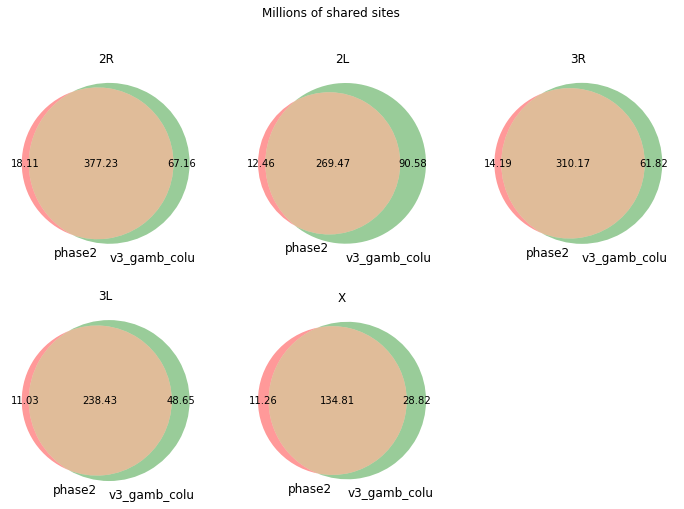

In [22]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt



f, axes = plt.subplots(2, 3, figsize=(12, 8))

for ix, chrom in enumerate(chrom_arms):

    d = np.round(venn[chrom] * 10e-6, 2)

    access_p2 = d[1, 1] + d[1, 0]
    access_p3 = d[0, 1] + d[1, 1]
    access_both = d[1, 1]
    access_p2_not_p3 = d[1, 0]
    access_p3_not_p2 = d[0, 1]

    i = ix // 3
    j = ix % 3
    venn2(subsets = (access_p2_not_p3, access_p3_not_p2, access_both), set_labels=("phase2", "v3_gamb_colu"), ax=axes[i, j])
    axes[i, j].set_title(chrom)

    
axes[-1, -1].axis('off')
f.suptitle("Millions of shared sites")
f.savefig("shared_sites_p2_p3_venn.png")

In [23]:
df = pd.concat(data_holder, axis=0, sort=False, names=["description", "chrom", "cross_id", "metric"])
df.name = "value"

In [24]:
df

description  chrom  cross_id  metric         
phase2       2R     B5        tpr                0.731028
                              fpr                0.078367
                              fdr                0.000714
                              tnr                0.921633
                              youden             0.652662
                                                   ...   
r100         X      37-3      fpr                1.000000
                              fdr                0.031099
                              tnr                0.000000
                              youden             0.000000
                              frac_accessible    1.000000
Name: value, Length: 750, dtype: float64

In [25]:
output = pd.pivot_table(
    pd.DataFrame(df).reset_index(level="metric"), 
    index=["description", "chrom", "cross_id"], 
    columns="metric", 
    values="value")

In [26]:
output

metric                           fdr       fpr  frac_accessible       tnr  \
description chrom cross_id                                                  
phase2      2L    37-3      0.002049  0.106601         0.580992  0.893399   
                  45-1      0.001660  0.105043         0.580992  0.894957   
                  73-2      0.001310  0.081861         0.580992  0.918139   
                  B5        0.000778  0.067623         0.580992  0.932377   
                  K6        0.000654  0.056652         0.580992  0.943348   
...                              ...       ...              ...       ...   
r50         X     37-3      0.031025  0.498727         0.499890  0.501273   
                  45-1      0.027303  0.499821         0.499890  0.500179   
                  73-2      0.022385  0.500262         0.499890  0.499738   
                  B5        0.032986  0.499527         0.499890  0.500473   
                  K6        0.019936  0.499514         0.499890  0.500486   

metric                           tpr    youden  
description chrom cross_id                      
phase2      2L    37-3      0.650019  0.543419  
                  45-1      0.650928  0.545884  
                  73-2      0.653564  0.571703  
                  B5        0.639615  0.571992  
                  K6        0.652258  0.595606  
...                              ...       ...  
r50         X     37-3      0.499940  0.001213  
                  45-1      0.499947  0.000127  
                  73-2      0.499907 -0.000355  
                  B5        0.499934  0.000407  
                  K6        0.499928  0.000414  

[125 rows x 6 columns]

In [27]:
output.to_csv("performance_stats_all.csv")

distributed.scheduler - INFO - Remove worker tcp://10.35.164.2:44437
distributed.core - INFO - Removing comms to tcp://10.35.164.2:44437
